In [1]:
import torch
import torchvision.transforms as T
import os
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt # for plotting
import torch # PyTorch package
import torchvision # load datasets
import torchvision.transforms as transforms # transform data
import torch.nn.functional as F # import convolution functions like Relu
from sklearn.decomposition import PCA
from random import randint

In [2]:
patch_h = 40
patch_w = 40
# feat_dim = 384 # vits14
# feat_dim = 768 # vitb14
# feat_dim = 1024 # vitl14
feat_dim = 1536 # vitg14

# dinov2_vits14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14')
# dinov2_vitb14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
# dinov2_vitl14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitl14')
dinov2_vitg14 = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitg14')

print(dinov2_vitg14)

Using cache found in /Users/ashwin/.cache/torch/hub/facebookresearch_dinov2_main
/Users/ashwin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/ashwin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/ashwin/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


DinoVisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1536, kernel_size=(14, 14), stride=(14, 14))
    (norm): Identity()
  )
  (blocks): ModuleList(
    (0-39): 40 x NestedTensorBlock(
      (norm1): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (attn): MemEffAttention(
        (qkv): Linear(in_features=1536, out_features=4608, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1536, out_features=1536, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): LayerScale()
      (drop_path1): Identity()
      (norm2): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
      (mlp): SwiGLUFFNFused(
        (w12): Linear(in_features=1536, out_features=8192, bias=True)
        (w3): Linear(in_features=4096, out_features=1536, bias=True)
      )
      (ls2): LayerScale()
      (drop_path2): Identity()
    )
  )
  (norm): LayerNorm((1536,), eps=1e-06, elementwise_affine=True)
  (head

In [3]:
# Caltech101 Dataset Preprocessing

transform = T.Compose([
    T.GaussianBlur(9, sigma=(0.1, 2.0)),
    T.Resize((patch_h * 14, patch_w * 14)),
    T.CenterCrop((patch_h * 14, patch_w * 14)),
    T.ToTensor(),
    #T.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

# set batch_size
batch_size = 1

# set number of workers
num_workers = 1

# load train data
trainset = torchvision.datasets.Caltech101(root='./data', download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

Files already downloaded and verified


In [4]:
# Removing the irrelevant class
classes = [d.name for d in os.scandir(os.path.join('./data', 'caltech101', '101_ObjectCategories')) if d.is_dir()]
classes.remove('BACKGROUND_Google')
classes.sort()         

In [5]:
# General transforms
t2im = transforms.ToPILImage()
im2t = transforms.PILToTensor()
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# Preparing a datalist containing index-wise categories.
data_list = [[]]*101
for i, data in enumerate(trainloader, 0):
    inputs, labels = data
    if data_list[labels] == []:
        data_list[labels] = [inputs]
    else:
        data_list[labels].append(inputs)
print([len(i) for i in data_list])

[435, 435, 200, 798, 55, 800, 42, 42, 47, 54, 46, 33, 128, 98, 43, 85, 91, 50, 43, 123, 47, 59, 62, 107, 47, 69, 73, 70, 50, 51, 57, 67, 52, 65, 68, 75, 64, 53, 64, 85, 67, 67, 45, 34, 34, 51, 99, 100, 42, 54, 88, 80, 31, 64, 86, 114, 61, 81, 78, 41, 66, 43, 40, 87, 32, 76, 55, 35, 39, 47, 38, 45, 53, 34, 57, 82, 59, 49, 40, 63, 39, 84, 57, 35, 64, 45, 86, 59, 64, 35, 85, 49, 86, 75, 239, 37, 59, 34, 56, 39, 60]


In [7]:
data_list[0][0].shape
# classes.index('elephant')

torch.Size([1, 3, 560, 560])

torch.Size([4, 3, 560, 560])
dict_keys(['x_norm_clstoken', 'x_norm_regtokens', 'x_norm_patchtokens', 'x_prenorm', 'masks'])
torch.Size([4, 1600, 1536])


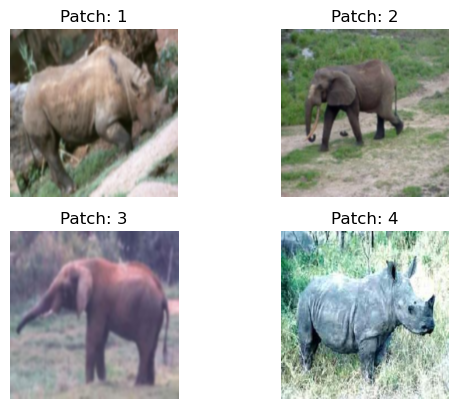

In [102]:
# Selecting a random patch and computing the embeddings using Dinov2
features = torch.zeros(4, patch_h * patch_w, feat_dim)
imgs_tensor = torch.zeros(4, 3, patch_h * 14, patch_w * 14)
fig, axs = plt.subplots(2,2)
q=0
categs = [76, 36, 36, 76]
#for c in range(len(data_list)):
for p in range(4):
    #categ = randint(0, 100)
    categ = categs[p]
    ind = randint(0, len(data_list[categ]))
    imgs_tensor[p] = torch.squeeze(data_list[categ][ind])
    axs[q][p%2].imshow(torch.permute(torch.squeeze(data_list[categ][ind]),(1,2,0)))
    axs[q][p%2].set_title("Patch: "+str(p+1))
    axs[q][p%2].axis('off')
    if p==1:
        q+=1
#   break
with torch.no_grad():
    print(imgs_tensor.shape)
    features_dict = dinov2_vitg14.forward_features(imgs_tensor)
    features = features_dict['x_norm_patchtokens']

print(features_dict.keys())
print(features.shape)
features = features.reshape(4 * patch_h * patch_w, feat_dim)

plt.show()

In [103]:
# Init PCA and transforming the features
pca = PCA(n_components=3)
pca.fit(features)
pca_features = pca.transform(features)

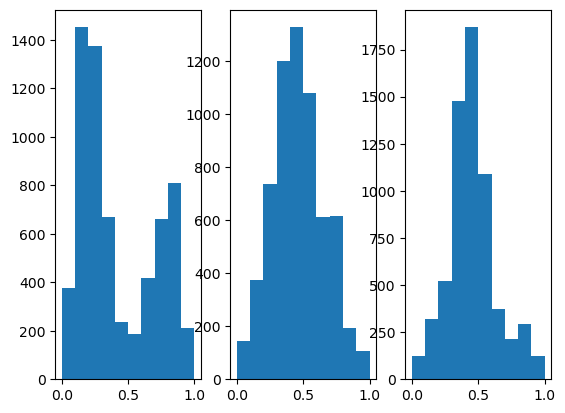

In [105]:
# Normalising the PCA features
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())
pca_features[:, 1] = (pca_features[:, 1] - pca_features[:, 1].min()) / (pca_features[:, 1].max() - pca_features[:, 1].min())
pca_features[:, 2] = (pca_features[:, 2] - pca_features[:, 2].min()) / (pca_features[:, 2].max() - pca_features[:, 2].min())

# visualize PCA components for finding a proper threshold
plt.subplot(1, 3, 1)
plt.hist(pca_features[:, 0])
plt.subplot(1, 3, 2)
plt.hist(pca_features[:, 1])
plt.subplot(1, 3, 3)
plt.hist(pca_features[:, 2])
plt.show()
plt.close()


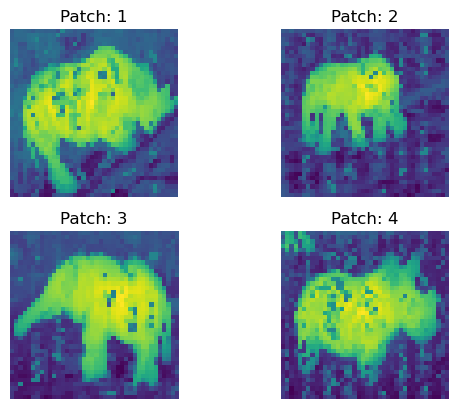

In [106]:
# To plot the first pca component
fig, axs = plt.subplots(2,2)
pca_features[:, 0] = (pca_features[:, 0] - pca_features[:, 0].min()) / (pca_features[:, 0].max() - pca_features[:, 0].min())
i=0
for m in range(2):
    for n in range(2):
        axs[m][n].imshow(pca_features[i * patch_h * patch_w: (i+1) * patch_h * patch_w, 0].reshape(patch_h, patch_w))
        axs[m][n].set_title("Patch: "+str(i+1))
        axs[m][n].axis('off')
        i+=1
plt.show()

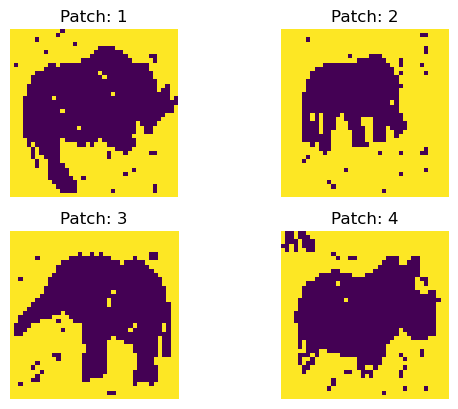

In [121]:
# segment using the first component
pca_features_bg = pca_features[:, 0] < 0.45
pca_features_fg = ~pca_features_bg
fig, axs = plt.subplots(2,2)

# plot the pca_features_bg
i=0
for m in range(2):
    for n in range(2):
        axs[m][n].imshow(pca_features_bg[i * patch_h * patch_w: (i+1) * patch_h * patch_w].reshape(patch_h, patch_w))
        axs[m][n].set_title("Patch: "+str(i+1))
        axs[m][n].axis('off')
        i+=1
plt.show()


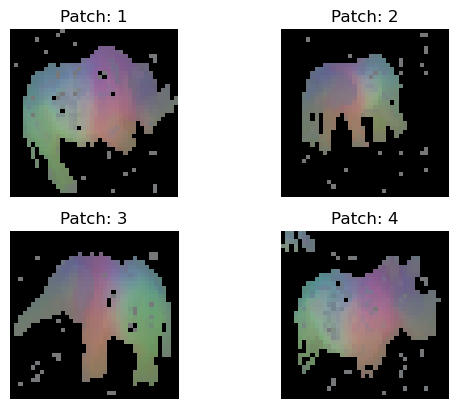

In [122]:
# PCA for only foreground patches
pca.fit(features[pca_features_fg])
pca_features_rem = pca.transform(features[pca_features_fg])
for i in range(3):
    # pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].min()) / (pca_features_rem[:, i].max() - pca_features_rem[:, i].min())
    # transform using mean and std, I personally found this transformation gives a better visualization
    pca_features_rem[:, i] = (pca_features_rem[:, i] - pca_features_rem[:, i].mean()) / (pca_features_rem[:, i].std() ** 2) + 0.5

pca_features_rgb = pca_features.copy()
pca_features_rgb[pca_features_bg] = 0
pca_features_rgb[pca_features_fg] = pca_features_rem

pca_features_rgb = pca_features_rgb.reshape(4, patch_h, patch_w, 3)

fig, axs = plt.subplots(2,2)
i=0
for m in range(2):
    for n in range(2):
        axs[m][n].imshow(pca_features_rgb[i][..., ::-1])
        axs[m][n].set_title("Patch: "+str(i+1))
        axs[m][n].axis('off')
        i+=1
#plt.savefig('features.png')
plt.show()

In [14]:
# Patch matching
def match_patches(patch1, patch2):
    pca = PCA(n_components=3)
    with torch.no_grad():
        p1_features_dict = dinov2_vitg14.forward_features(patch1)
        p2_features_dict = dinov2_vitg14.forward_features(patch2)
    p1_features = p1_features_dict['x_norm_patchtokens']
    p2_features = p2_features_dict['x_norm_patchtokens']
    p1_features = torch.from_numpy(pca.fit_transform(p1_features.reshape(4 * patch_h * patch_w, feat_dim)))
    p2_features = torch.from_numpy(pca.fit_transform(p2_features.reshape(4 * patch_h * patch_w, feat_dim)))
    cosine_sim = F.cosine_similarity(p1_features, p2_features)
    euclidean_distance = torch.sqrt(torch.sum(torch.pow(torch.subtract(p1_features, p2_features), 2), dim=0)) 
    pairwise_distance = F.pairwise_distance(p1_features, p2_features)
    mean_cosine_sim = cosine_sim.mean().item()
    mean_euclidean_distance = euclidean_distance.mean().item()
    mean_pairwise_distance = pairwise_distance.mean().item()
    print(mean_cosine_sim, mean_euclidean_distance, mean_pairwise_distance)

def get_imgtensor(data_list, c):
    imgs_tensor = torch.zeros(4, 3, patch_h * 14, patch_w * 14)
    fig, axs = plt.subplots(2,2)
    q=0
    for p in range(4):
        ind = randint(0, len(data_list[c]))
        imgs_tensor[p] = torch.squeeze(data_list[c][ind])
        axs[q][p%2].imshow(torch.permute(torch.squeeze(data_list[c][ind]),(1,2,0)))
        axs[q][p%2].set_title("Patch: "+str(p+1))
        axs[q][p%2].axis('off')
        if p==1:
            q+=1
    plt.show()
    return imgs_tensor



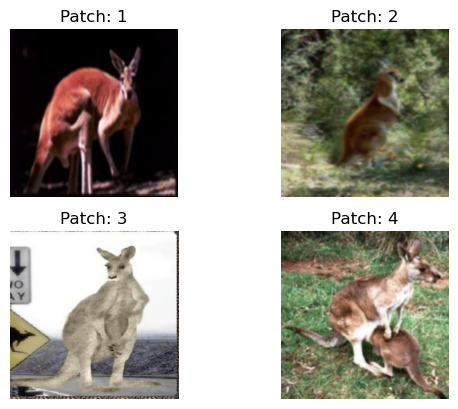

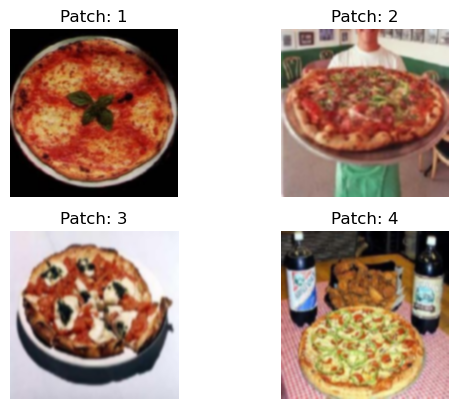

0.14579405480791904 1364.573369123508 27.26266176022903


In [15]:
# No match
img_tensor1 = get_imgtensor(data_list, 54)
img_tensor2 = get_imgtensor(data_list, 72)
match_patches(img_tensor1, img_tensor2)

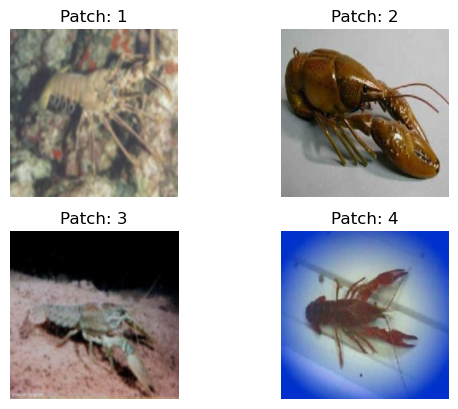

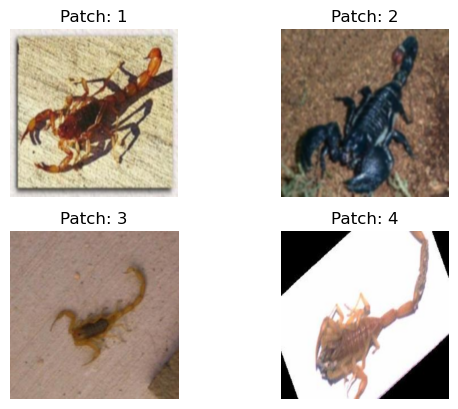

0.36674422129308853 1146.4631557160153 22.497747559797517


In [16]:
# Partial Match
img_tensor1 = get_imgtensor(data_list, 27)
img_tensor2 = get_imgtensor(data_list, 81)
match_patches(img_tensor1, img_tensor2)

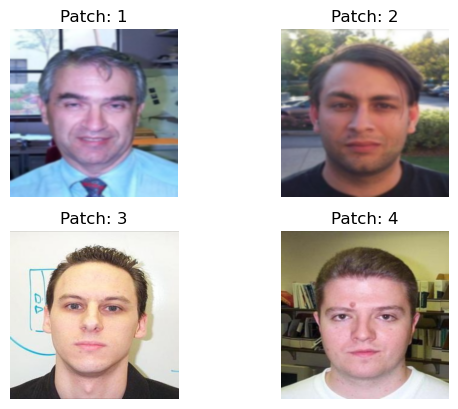

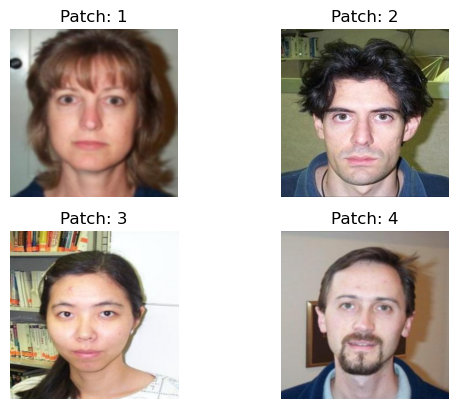

0.7342937967258149 792.8334297214333 15.191014512522736


In [19]:
# Full match
img_tensor1 = get_imgtensor(data_list, 1)
img_tensor2 = get_imgtensor(data_list, 1)
match_patches(img_tensor1, img_tensor2)